### Rappel Google Colab

Tout d'abord, sélectionnez l'option GPU de Colab avec *Edit > Notebook settings* et sélectionner GPU comme Hardware accelerator. 
Installer ensuite deeplib avec la commande suivante:

In [ ]:
!pip install git+https://github.com/ulaval-damas/glo4030-labs.git

# Laboratoire 9: MLOps - Introduction aux librairies `PyTorch Lightning` et `Weights & Biases`

Dans les laboratoires du cours, nous utilisons habituellement les librairies `deeplib` et `Poutyne`, qui offrent beaucoup de fonctionnalités pertinentes au développement et à l'analyse de réseaux de neurones. Dans ce laboratoire, nous allons introduire différents outils très utiles pour le développement et la gestion de projets plus complexes, notamment les travaux pratiques et le projet de session. Nous nous concentrerons sur [`PyTorch Lightning`](https://lightning.ai/docs/pytorch/stable/) (`Lightning`), une librairie qui simplifie grandement l'entraînement et l'évaluation de modèles avec `PyTorch`. Par la suite, nous aurons recours à [`Weights & Biases`](https://docs.wandb.ai/) (`WandB`) pour la recherche d'hyperparamètres et pour la visualisation des résultats.

Vous pouvez voir `Lightning` comme une version plus complète et puissante de `Poutyne` utilisé dans les autres laboratoires du cours. Il permet notamment de :
- Simplifier la gestion de données et les boucles d'entraînement;
- Utiliser différentes précisions de calcul et multiples GPUs;
- Inclure des fonctions modulaires *plug-and-play*, telles que des métriques et des callbacks;
- Suivre les entrâinements avec des logs, notamment avec `WandB`.

Pour `WandB`, nous verrons seulement la recherche d'hyperparamètres et la visualisation, mais vous pouvez regarder la [documentation](https://docs.wandb.ai) pour en savoir plus sur toutes les autres fonctionnalités.

Ce laboratoire se veut une introduction aux différents outils souvent utilisés dans la phase de développement du MLOps. Le MLOps reste toutefois beaucoup plus complexe que seulement la partie du développement. Nous pouvons voir le MLOps comme étant un pipeline de développement itératif découpé en 3 phases : 
- ML : développement de modèles et préparation de jeux de données;
- DEV : entraînement, expérimentation et optimisation de modèles;
- OPS : déploiement, inférence et exploitation de modèles.

Dans le laboratoire, nous allons résoudre une tâche de classification sur le jeu de données `CIFAR-10`, comme dans les autres laboratoires, mais en utilisant `Lightning` et `WandB` au lieu de `deeplib` et `Poutyne`.

Nous nous trouvons ici dans la phase DEV, comme nous utiliserons des modèles et des données déjà préparées dans la phase ML.

In [1]:
%matplotlib inline

import os

import lightning as L
import torch
import torchmetrics
import torchvision.transforms as T
from torch.utils.data import DataLoader, random_split
from torchvision.datasets.cifar import CIFAR10
from torchvision.models import ResNet18_Weights, resnet18

/home/daduc59/Documents/projects/GLO-4030/glo4030-labs/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Création d'un compte `Weights & Biases`

La première étape du laboratoire est de se créer un compte sur `WandB`. Vous pouvez cliquer sur ce [lien](https://wandb.ai). Pour avoir un abonnement gratuit pour étudiant, il suffit de faire une demande [ici](https://wandb.ai/site/research/).

## Création de notre module de données `Lightning`

La première étape a réaliser avant même d'entraîner un modèle est d'importer nos données.

Jusqu'ici, le téléchargement des données était toujours fait par `deeplib`. `Lightning` offre une classe [`LightningDataModule`](https://lightning.ai/docs/pytorch/stable/data/datamodule.html) qui permet de bien structurer le téléchargement des données jusqu'à la création de `Dataloaders`. Voyons comment nous créons un module de données `Lightning`.

Le code est commenté pour permettre de bien suivre les différentes étapes de création d'un module de données `Lightning`. N'hésitez pas à visiter la [documentation](https://lightning.ai/docs/pytorch/stable/data/datamodule.html) pour en savoir plus.

In [2]:
# Nous utilisons le même emplacement que deeplib pour éviter de retélécharger inutilement
from deeplib.datasets import BASE_PATH

base_cifar10_path = os.path.join(BASE_PATH, "cifar10")

In [3]:
# Nous créons ici un DataModule Lightning pour le jeu de données CIFAR-10


class Cifar10DataModule(L.LightningDataModule):
    """
    DataModule pour le jeu de données CIFAR-10.
    Paramètres:
        path (str): Répertoire où les données seront stockées.
        batch_size (int): Taille de la batch.
        val_split (float): Fraction des données d'entraînement à utiliser pour la validation.
        num_workers (int): Nombre de workers pour le chargement des données.
    """

    def __init__(
        self,
        path=base_cifar10_path,
        batch_size=128,
        val_split=0.1,
        num_workers=4,
    ):
        super().__init__()

        self.data_dir = path
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.val_split = val_split

        # Un transformation qui convertit automatiquement différents formats d'entrée (e.g., PIL, numpy) en tensor normalisée entre [0, 1].
        # Avec T.Compose, vous pourriez combiner avec diverses augmentations de données afin de bonifier l'entraînement!
        self.transform = T.ToTensor()

    # Téléchargement des données, appelé sur un seul coeur CPU pour éviter les conflits.
    def prepare_data(self):
        CIFAR10(self.data_dir, train=True, download=True)
        CIFAR10(self.data_dir, train=False, download=True)

    # Configuration des datasets pour l'entraînement, la validation et le test.
    # Méthode appelée sur chaque GPU lors d'un entraînement multi-GPU.
    def setup(self, stage=None):
        full_train = CIFAR10(
            self.data_dir, train=True, transform=self.transform, download=False
        )
        test = CIFAR10(
            self.data_dir, train=False, transform=self.transform, download=False
        )

        num_train = len(full_train)
        val_size = int(self.val_split * num_train)
        train_size = num_train - val_size
        train, val = random_split(full_train, [train_size, val_size])

        self.train_dataset = train
        self.val_dataset = val
        self.test_dataset = test

    # Création des DataLoaders pour l'entraînement, la validation et le test.
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            # Évite de réinitialiser les workers à chaque epoch, habituellement plus rapide
            persistent_workers=True,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            persistent_workers=True,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
        )

Nous pouvons appeler la fonction `seed_everything`, qui assure la reproductibilité de nos expérimentations.
Ça affecte notamment le résultat du `random_split`, `RandomCrop`, etc.

In [4]:
L.seed_everything(seed=42, verbose=False)

42

In [5]:
# Nous créons ici un DataModule Lightning pour le jeu de données CIFAR-10
cifar10_datamodule = Cifar10DataModule()

Visualisons rapidement que le chargement d'images fonctionne.
Nous allons utiliser `torchshow`, une librairie qui simplifie beaucoup le traitement de tensors.
Ça prend notamment en compte le format des images, qui sont ici normalisées.
Voici la [documentation](https://github.com/xwying/torchshow) pour ceux qui veulent en savoir plus.

/home/daduc59/Documents/projects/GLO-4030/glo4030-labs/.venv/lib/python3.12/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


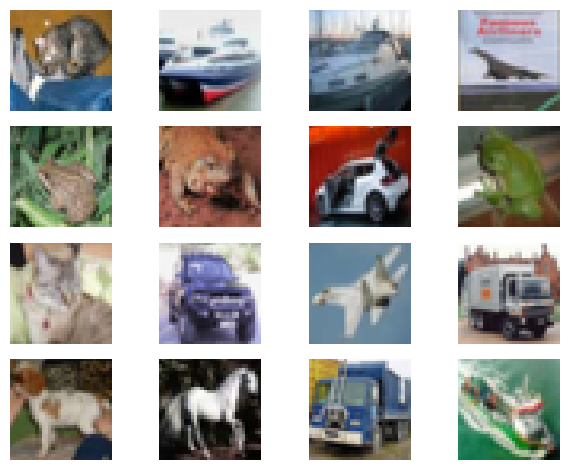

In [6]:
import torchshow

N_IMAGES = 16
N_ROWS = 4

# En temps normal, vous n'aurez pas besoin d'appeler ces fonctions
cifar10_datamodule.setup()
cifar10_test = cifar10_datamodule.test_dataloader()
cifar10_train = cifar10_datamodule.train_dataloader()

# Chaque itération retourne une batch de 128 images avec leurs labels (voir la définition plus haut)
images, labels = next(iter(cifar10_test))
torchshow.show(images[:N_IMAGES], nrow=N_ROWS)

## Création d'un modèle `Lightning` avec [`LightningModule`](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html)

Maintenant que nous avons le `LightningDataModule`, nous pouvons créer un module `Lightning` pour l'entraînement un modèle.
Pour simplifier encore plus l'implémentation, nous utiliserons un modèle [`ResNet18` de `torchvision`](https://docs.pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html).
Nous visualiserons aussi ce que le préentraînement peut apporter, avec les poids d'un modèle entraîné sur `ImageNet1K`.

#### Exercice

- Regardez la [documentation sur les logs](https://lightning.ai/docs/pytorch/stable/extensions/logging.html#:~:text=instantiating%20a%20logger.-,Logging%20from%20a%20LightningModule,-Lightning%20offers%20automatic) de `Lightning` et ajouter des logs pour la perte pour: `training_step`, `validation_step` et `test_step`. Pour la perte en entraînement et en validation, ajoutez l'argument `prog_bar=True` afin d'afficher la perte dans la barre de progrès.

In [7]:
class LightningResNet18(L.LightningModule):
    def __init__(
        self,
        classes,
        lr=0.1,
        momentum=0.9,
        weight_decay=5e-4,
    ):
        super().__init__()
        # Enregistre tous les paramètres dans self.hparams, et ajoute dans les logs
        self.save_hyperparameters()

        # Initialise un réseau de neurones préentraîné sur ImageNet1K
        self.model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        # Remplace la couche de sortie pour de l'apprentissage par transfert sur CIFAR-10
        num_classes = len(classes)
        self.model.fc = torch.nn.Linear(self.model.fc.in_features, num_classes)
        # Ajout de la fonction de perte
        self.criterion = torch.nn.CrossEntropyLoss()

    # Initialisation de l'optimiseur et du scheduler de taux d'apprentissage
    def configure_optimizers(self):
        # Usage des paramètres enregistrés dans self.hparams
        optimizer = torch.optim.SGD(
            params=self.parameters(),
            lr=self.hparams.lr,
            momentum=self.hparams.momentum,
            weight_decay=self.hparams.weight_decay,
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer=optimizer,
            patience=1,
            factor=0.1,
        )
        scheduler_config = {
            "scheduler": scheduler,
            "monitor": "val_loss",
        }
        return [optimizer], [scheduler_config]

    def forward(self, x):
        return self.model(x)

    # Appelé pour chaque minibatch (step) d'entraînement
    def training_step(self, batch):
        images, labels = batch
        outputs = self(images)

        loss = self.criterion(outputs, labels)
        # TODO: Ajoutez ici un log pour la perte en entraînement, et affichez le résultat sur la barre de progrès
        self.log("train_loss", loss, prog_bar=True)

        return loss

    # Appelé pour chaque minibatch (step) de validation
    def validation_step(self, batch):
        images, labels = batch
        outputs = self(images)

        loss = self.criterion(outputs, labels)
        # TODO: Ajoutez ici un log pour la perte en validation, et affichez le résultat sur la barre de progrès
        self.log("val_loss", loss, prog_bar=True)

        return loss

    # Appelé pour chaque minibatch (step) de test
    def test_step(self, batch):
        images, labels = batch
        outputs = self(images)

        loss = self.criterion(outputs, labels)
        # TODO: Ajoutez ici un log pour la perte en test
        self.log("test_loss", loss)

        return loss

Faisons un test rapide pour valider que le module peut être initialisé correctement.

In [8]:
# Nous allons chercher le dictionnaire des classes dans CIFAR-10, qui serviront au logging
classes = cifar10_train.dataset.dataset.class_to_idx
model = LightningResNet18(classes=classes)

print(model)

LightningResNet18(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

Pour valider que le module fonctionne correctement, nous pouvons utiliser `torchinfo`.
Par exemple, nous pouvons voir la taille des tensors intermédiaires lors du traitement, et estimer la quantité de mémoire nécessaire pour le traitement d'une batch.
Ici, nous évaluons pour une batch de 128 images RGB de 224x224 pixels.
Pour en savoir plus sur `torchinfo`, vous pouvez visiter la [documentation](https://github.com/TylerYep/torchinfo).

In [9]:
import torchinfo

b, c, h, w = 128, 3, 224, 224

torchinfo.summary(model, input_size=(b, c, h, w))

Layer (type:depth-idx)                        Output Shape              Param #
LightningResNet18                             [128, 10]                 --
├─ResNet: 1-1                                 [128, 10]                 --
│    └─Conv2d: 2-1                            [128, 64, 112, 112]       9,408
│    └─BatchNorm2d: 2-2                       [128, 64, 112, 112]       128
│    └─ReLU: 2-3                              [128, 64, 112, 112]       --
│    └─MaxPool2d: 2-4                         [128, 64, 56, 56]         --
│    └─Sequential: 2-5                        [128, 64, 56, 56]         --
│    │    └─BasicBlock: 3-1                   [128, 64, 56, 56]         73,984
│    │    └─BasicBlock: 3-2                   [128, 64, 56, 56]         73,984
│    └─Sequential: 2-6                        [128, 128, 28, 28]        --
│    │    └─BasicBlock: 3-3                   [128, 128, 28, 28]        230,144
│    │    └─BasicBlock: 3-4                   [128, 128, 28, 28]        295,42

## Entraînement avec un `Trainer` de `Lightning`
Nous allons maintenant créer un [`Trainer`](https://lightning.ai/docs/pytorch/stable/common/trainer.html), qui gère plusieurs aspects de la boucle d'entraînement et d'évaluation.

In [10]:
# Cette partie n'est pas importante, et n'est habituellement pas nécessaire
# Nous créons une barre de progrès custom pour éviter un bug visuel sur la plateforme ICE
from lightning.pytorch.callbacks import TQDMProgressBar


class NoValProgressBar(TQDMProgressBar):
    def init_validation_tqdm(self):
        bar = super().init_validation_tqdm()
        bar.disable = True
        return bar

In [11]:
trainer = L.Trainer(
    # En spécifiant "gpu" à l'argument accelerator, nous pouvons entraîner sur GPU.
    # En arrière plan, les transferts de données sur GPU sont gérées de manière automatique.
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    # Si plusieurs GPU sont disponibles, nous pouvons simplement remplacer "auto" par le nombre de GPU.
    # Le code sera alors exécuté sur tous les GPU disponibles sans besoin de modifier le reste du code.
    devices="auto",
    # Le nombre maximal d'epochs pour l'entraînement
    max_epochs=5,
    # Nous allons revenir sur les callbacks plus loin
    callbacks=[NoValProgressBar()],
)

/home/daduc59/Documents/projects/GLO-4030/glo4030-labs/.venv/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/daduc59/Documents/projects/GLO-4030/glo4030-la ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/daduc59/Documents/projects/GLO-4030/glo4030-labs/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable

Validons que la boucle d'entraînement fonctionne.

In [12]:
# Cette fonction gère les boucles d'entraînement et de validation
trainer.fit(model, datamodule=cifar10_datamodule)
# Cette fonction va chercher le modèle utilisé lors du fit, et gère la boucle de test
trainer.test(model, datamodule=cifar10_datamodule)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model     | ResNet           | 11.2 M | train | 0    
1 | criterion | CrossEntropyLoss | 0      | train | 0    
---------------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.72

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/daduc59/Documents/projects/GLO-4030/glo4030-labs/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.


Epoch 4: 100%|██████████| 352/352 [00:02<00:00, 170.26it/s, v_num=1, train_loss=0.936, val_loss=1.610]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 352/352 [00:02<00:00, 162.10it/s, v_num=1, train_loss=0.936, val_loss=1.610]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 79/79 [00:00<00:00, 390.10it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.6133322715759277
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.6133322715759277}]

Vous devriez trouver un nouveau dossier `lightning_logs` dans le répertoire de laboratoires.
Ce dossier contient la liste d'hyperparamètres, les métriques et le plus dernier checkpoint.

## `Weights & Biases`

Procédons maintenant à l'ajout d'un logger `WandB`, qui nous permettra de suivre et visualiser nos entraînements en temps réel.

La première étape est de vous connecter avec votre compte `WandB`.
Choissisez l'option *Use an existing W&B account*.

In [13]:
import wandb

wandb.login()

wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from WANDB_API_KEY.
wandb: Currently logged in as: daduc59 (norlab-ulaval) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

Ajoutons maintenant un `WandbLogger` au `Trainer`.

In [14]:
from lightning.pytorch.loggers import WandbLogger

logger = WandbLogger(project="glo4030-labo9")

trainer = L.Trainer(
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices="auto",
    max_epochs=20,
    # Notre logger WandB
    logger=logger,
    callbacks=[NoValProgressBar()],
)

/home/daduc59/Documents/projects/GLO-4030/glo4030-labs/.venv/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/daduc59/Documents/projects/GLO-4030/glo4030-la ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


In [15]:
L.seed_everything(seed=42, verbose=False)

model = LightningResNet18(classes=classes)

trainer.fit(model, datamodule=cifar10_datamodule)
trainer.test(model, datamodule=cifar10_datamodule)

# Nous appelons cette fonction pour indiquer que l'entraînement est terminé et assurer la sauvegarde des résultats
wandb.finish()

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
/home/daduc59/Documents/projects/GLO-4030/glo4030-labs/.venv/lib/python3.12/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")
wandb: WARNING The anonymous setting has no effect and will be removed in a future version.


/home/daduc59/Documents/projects/GLO-4030/glo4030-labs/.venv/lib/python3.12/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model     | ResNet           | 11.2 M | train | 0    
1 | criterion | CrossEntropyLoss | 0      | train | 0    
---------------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode
0         Total Flops


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/daduc59/Documents/projects/GLO-4030/glo4030-labs/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.


Epoch 19: 100%|██████████| 352/352 [00:02<00:00, 160.14it/s, v_num=iojl, train_loss=0.247, val_loss=0.773] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 352/352 [00:02<00:00, 153.92it/s, v_num=iojl, train_loss=0.247, val_loss=0.773]


/home/daduc59/Documents/projects/GLO-4030/glo4030-labs/.venv/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/daduc59/Documents/projects/GLO-4030/glo4030-la ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 79/79 [00:00<00:00, 406.15it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7698116898536682
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇█████
test_loss,▁
train_loss,█▇▆▅▅▄▄▄▄▄▃▃▃▃▃▂▃▂▁▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇██
val_loss,▇▆█▅▅▄▃▂▃▃▁▁▁▁▁▁▁▁▁▁
epoch,20
test_loss,0.76981
train_loss,0.17167
trainer/global_step,7040
val_loss,0.77348


Vous pouvez maintenant visualiser les métriques de l'entraînement et l'évaluation sur le site de `WandB`.
Le lien est habituellement indiqué avant et après l'entraînement, mais sinon vous pouvez trouver dans votre projet `glo4030-labo9` sur le site de [WandB](https://wandb.ai).

Nous vous invitons à visiter les différents onglets (e.g., train, val, test, System), et à ouvrir l'onglet `Overview` (cliquer sur l'entraînement, puis sur le deuxième onglet en haut) pour comprendre la disposition des informations.

## `Torchmetrics`
Bien que la perte (loss) soit utile, nous voudrions des métriques plus fiables et concrètes pour évaluer la performance.
Pour cela, nous utiliserons `torchmetrics`, qui regroupe de nombreuses métriques allant de la classification à la détection d'objets.
Vous pouvez voir les différentes métriques disponible en suivent ce [lien](https://lightning.ai/docs/torchmetrics/stable/) vers la documentation.

Ajoutons par exemple l'accuracy. Nous ajouterons l'accuracy moyenne et celle par classe.

Pour ce faire, nous avons besoin de créer un nouveau module `Lightning`.
Les parties modifiées du module sont commentées pour votre compréhension.

In [16]:
class LightningResNet18(L.LightningModule):
    def __init__(
        self,
        classes,
        lr=0.1,
        momentum=0.9,
        weight_decay=5e-4,
    ):
        super().__init__()
        self.save_hyperparameters()

        self.classes = classes
        self.num_classes = len(classes)

        self.model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        self.model.fc = torch.nn.Linear(self.model.fc.in_features, self.num_classes)
        self.criterion = torch.nn.CrossEntropyLoss()

        # Nous devons initialiser une métrique par ensemble de données, puisque les résultats sont accumulés lors de chaque batch
        # Nous avons plusieurs classes, alors nous spécifions task="multiclass" et le nombre de classes
        self.train_acc = torchmetrics.Accuracy(
            task="multiclass", num_classes=self.num_classes
        )
        self.val_acc = torchmetrics.Accuracy(
            task="multiclass", num_classes=self.num_classes
        )
        self.test_acc = torchmetrics.Accuracy(
            task="multiclass", num_classes=self.num_classes
        )

        # Par défaut, la métrique calcule la moyenne sur toutes les données (micro average)
        # Ajoutons également une mesure de la performance par classe
        # Puisque c'est plus lourd à calculer, nous allons uniquement l'ajouter en évaluation
        self.val_acc_class = torchmetrics.Accuracy(
            task="multiclass", num_classes=self.num_classes, average="none"
        )
        self.test_acc_class = torchmetrics.Accuracy(
            task="multiclass", num_classes=self.num_classes, average="none"
        )

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(
            params=self.parameters(),
            lr=self.hparams.lr,
            momentum=self.hparams.momentum,
            weight_decay=self.hparams.weight_decay,
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer=optimizer,
            patience=1,
            factor=0.1,
        )
        scheduler_config = {
            "scheduler": scheduler,
            # Nous changeons la métrique monitorée par val_acc, puisque ça représente mieux la performance réelle
            "monitor": "val_acc",
        }
        return [optimizer], [scheduler_config]

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch):
        images, labels = batch
        outputs = self(images)

        loss = self.criterion(outputs, labels)
        self.log("train_loss", loss, prog_bar=True)

        # Il y a plusieurs approches pour calculer et enregistrer les métriques
        # Ici, nous appelons update pour calculer les résultats pour la minibatch actuelle
        # Lorsque nous appelons log avec `on_epoch`, torchmetrics s'occupe d'accumuler les résultats pour l'epoch complète
        self.train_acc.update(outputs, labels)
        self.log(
            "train_acc", self.train_acc, prog_bar=True, on_step=False, on_epoch=True
        )

        return loss

    def validation_step(self, batch):
        images, labels = batch
        outputs = self(images)

        loss = self.criterion(outputs, labels)
        self.log("val_loss", loss, prog_bar=True)

        self.val_acc.update(outputs, labels)
        self.log("val_acc", self.val_acc, prog_bar=True, on_epoch=True)

        # Pour bien sauvegarder les métriques par classe, ça demande un peu de travail à la main
        self.val_acc_class.update(outputs, labels)
        # Nous allons chercher la liste de résultats
        acc_class_results = self.val_acc_class.compute()
        for class_name, acc_class_result in zip(
            self.hparams.classes, acc_class_results
        ):
            # Nous ajoutons le nom d'une classe à sa métrique respective
            # D'ailleurs, nous pouvons ajouter une section avec le format "<section>/<metric>"
            # Ça permet de séparer les métriques par classe, autrement ça peut être lourd à visualiser
            self.log(
                f"val_per_class/acc_{class_name}",
                acc_class_result,
                on_step=False,
                on_epoch=True,
            )

        return loss

    def test_step(self, batch):
        images, labels = batch
        outputs = self(images)

        loss = self.criterion(outputs, labels)
        self.log("test_loss", loss)

        self.test_acc.update(outputs, labels)
        self.log("test_acc", self.test_acc, prog_bar=True, on_epoch=True)

        # Même chose qu'en val, avec les métriques respectives
        self.test_acc_class.update(outputs, labels)
        acc_class_results = self.test_acc_class.compute()
        for class_name, acc_class_result in zip(
            self.hparams.classes, acc_class_results
        ):
            self.log(
                f"test_per_class/acc_{class_name}",
                acc_class_result,
                on_step=False,
                on_epoch=True,
            )

        return loss

Effectuons un entraînement avec ce mouveau module pour visualiser l'accuracy.

In [17]:
L.seed_everything(seed=42, verbose=False)

logger = WandbLogger(project="glo4030-labo9")

trainer = L.Trainer(
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices="auto",
    max_epochs=20,
    logger=logger,
    callbacks=[NoValProgressBar()],
)

model = LightningResNet18(classes=classes)

trainer.fit(model, datamodule=cifar10_datamodule)
trainer.test(model, datamodule=cifar10_datamodule)

wandb.finish()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


/home/daduc59/Documents/projects/GLO-4030/glo4030-labs/.venv/lib/python3.12/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode  | FLOPs
----------------------------------------------------------------------
0 | model          | ResNet             | 11.2 M | train | 0    
1 | criterion      | CrossEntropyLoss   | 0      | train | 0    
2 | train_acc      | MulticlassAccuracy | 0      | train | 0    
3 | val_acc        | MulticlassAccuracy | 0      | train | 0    
4 | test_acc       | MulticlassAccuracy | 0      | train | 0    
5 | val_acc_class  | MulticlassAccuracy | 0      | train | 0    
6 | test_acc_class | MulticlassAccuracy | 0      | train | 0    
--------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/daduc59/Documents/projects/GLO-4030/glo4030-labs/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.


Epoch 19: 100%|██████████| 352/352 [00:02<00:00, 151.52it/s, v_num=47nr, train_loss=1.130, val_loss=1.170, val_acc=0.572, train_acc=0.610]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 352/352 [00:02<00:00, 144.86it/s, v_num=47nr, train_loss=1.130, val_loss=1.170, val_acc=0.572, train_acc=0.610]


/home/daduc59/Documents/projects/GLO-4030/glo4030-labs/.venv/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/daduc59/Documents/projects/GLO-4030/glo4030-la ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 79/79 [00:00<00:00, 216.08it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         Test metric                 DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          test_acc                 0.585099995136261
          test_loss               1.1477127075195312
 test_per_class/acc_airplane      0.6164990663528442
test_per_class/acc_automobile     0.7215534448623657
   test_per_class/acc_bird        0.3988710641860962
   test_per_class/acc_cat         0.39445745944976807
   test_per_class/acc_deer        0.49801650643348694
   test_per_class/acc_dog         0.4696406126022339
   test_per_class/acc_frog        0.6955812573432922
  test_per_class/acc_horse        0.6645344495773315
   test_per_class/acc_ship        0.7614283561706543
  test_per_class/acc_truck        0.6550361514091492

epoch,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇█
test_acc,▁
test_loss,▁
test_per_class/acc_airplane,▁
test_per_class/acc_automobile,▁
test_per_class/acc_bird,▁
test_per_class/acc_cat,▁
test_per_class/acc_deer,▁
test_per_class/acc_dog,▁
test_per_class/acc_frog,▁
+18,...


Prenez le temps de regarder les résultats sur `WandB`. Vous devriez observer que la performance n'est pas égale pour toutes les classes.

## `Callbacks`
Vous devriez remarquer que val_acc ne s'améliore pas lors des dernières epochs. Pour ajouter du early stopping, ainsi que d'autres fonctions utilitaires, nous pouvons utiliser des `Callbacks`. Plusieurs `Callbacks` existent; vous pouvez trouver plus d'informations sur ceux-ci dans la [documentation](https://lightning.ai/docs/pytorch/stable/extensions/callbacks.html).

In [18]:
L.seed_everything(seed=42, verbose=False)

logger = WandbLogger(project="glo4030-labo9")

# Nous ajoutons quelques Callbacks, des fonctions qui sont appelées périodiquement lors de l'entraînement
from lightning.pytorch.callbacks import (
    EarlyStopping,
    LearningRateMonitor,
    ModelCheckpoint,
)

callbacks = [
    # Arrêter l'entraînement après X epochs sans amélioration d'un delta Y
    EarlyStopping(
        # La métrique que nous monitorons
        monitor="val_acc",
        # L'amélioration minimal pour continuer
        min_delta=0.01,
        # Le nombre d'epochs à attendre pour une amélioration
        patience=5,
        # Nous voulons maximiser la métrique que nous monitorons
        mode="max",
    ),
    # Enregistrer le taux d'apprentissage lors de l'entraînement
    LearningRateMonitor(),
    # Sauvegarder le meilleur checkpoint plutôt que celui de la dernière epoch
    ModelCheckpoint(
        # Nous pouvons inclure certaines informations dans le nom du checkpoint
        filename="resnet18-cifar10-{epoch:04d}-{val_acc:.4f}",
        monitor="val_acc",
        mode="max",
    ),
    NoValProgressBar(),
]

trainer = L.Trainer(
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices="auto",
    max_epochs=20,
    logger=logger,
    callbacks=callbacks,
)

model = LightningResNet18(classes=classes)

trainer.fit(model, datamodule=cifar10_datamodule)
# Nous pouvons spécifier de tester sur le meilleur checkpoint
trainer.test(model, datamodule=cifar10_datamodule, ckpt_path="best")

wandb.finish()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


/home/daduc59/Documents/projects/GLO-4030/glo4030-labs/.venv/lib/python3.12/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode  | FLOPs
----------------------------------------------------------------------
0 | model          | ResNet             | 11.2 M | train | 0    
1 | criterion      | CrossEntropyLoss   | 0      | train | 0    
2 | train_acc      | MulticlassAccuracy | 0      | train | 0    
3 | val_acc        | MulticlassAccuracy | 0      | train | 0    
4 | test_acc       | MulticlassAccuracy | 0      | train | 0    
5 | val_acc_class  | MulticlassAccuracy | 0      | train | 0    
6 | test_acc_class | MulticlassAccuracy | 0      | train | 0    
--------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/daduc59/Documents/projects/GLO-4030/glo4030-labs/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.


Epoch 10: 100%|██████████| 352/352 [00:02<00:00, 148.76it/s, v_num=8fia, train_loss=1.250, val_loss=1.110, val_acc=0.600, train_acc=0.628]


Restoring states from the checkpoint path at ./glo4030-labo9/niy68fia/checkpoints/resnet18-cifar10-epoch=0010-val_acc=0.6000.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./glo4030-labo9/niy68fia/checkpoints/resnet18-cifar10-epoch=0010-val_acc=0.6000.ckpt


Testing DataLoader 0: 100%|██████████| 79/79 [00:00<00:00, 221.73it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         Test metric                 DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          test_acc                0.6158999800682068
          test_loss               1.0717846155166626
 test_per_class/acc_airplane      0.6780124306678772
test_per_class/acc_automobile     0.7149211168289185
   test_per_class/acc_bird        0.4548591673374176
   test_per_class/acc_cat         0.40209177136421204
   test_per_class/acc_deer        0.5086181163787842
   test_per_class/acc_dog         0.5009417533874512
   test_per_class/acc_frog        0.7409895062446594
  test_per_class/acc_horse        0.6781396865844727
   test_per_class/acc_ship        0.7902348637580872
  test_per_class/acc_truck        0.6684834957122803


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇█████
lr-SGD,███▂▂▁▁▁▁▁▁
test_acc,▁
test_loss,▁
test_per_class/acc_airplane,▁
test_per_class/acc_automobile,▁
test_per_class/acc_bird,▁
test_per_class/acc_cat,▁
test_per_class/acc_deer,▁
test_per_class/acc_dog,▁
+19,...


Vous pouvez valider que l'entraînement a arrêté préemptivement, et que le checkpoint (qui se trouve dans le dossier de la run, par exemple glo4030-labo9/<run_id>) contient les informations que nous voulions.

Vous trouvez peut-être que l'entraînement est rapide, mais rappelez-vous que nous traitons actuellement un projet simple.
Pour de grands projets d'apprentissage profond, les entraînements peuvent prendre plusieurs heures, voire plusieurs jours!

## Les différentes précisions
Pour accélérer l'entraînement et l'inférence, nous pouvons modifier la précision des calculs utilisée par `PyTorch`.
Nous vous invitons fortement à lire [cette section](https://en.wikipedia.org/wiki/Bfloat16_floating-point_format#bfloat16_floating-point_format) de la page Wikipedia sur le format bfloat16.

### Questions
- Quel est l'avantage d'utiliser un format de précision avec plus, ou moins, de bits?
- Pouvez-vous penser à quelques opérations qui ne se traduiraient pas bien en plus basse précision?
- Comment se distinguent le format float16 et bfloat16? Comparez-les avec IEEE 754 float32.
### Réponses
- La vitesse de calcul, ainsi que la vitesse de transferts CPU <-> GPU est directement influencée. Pour certains calculs, une plus grande précision est cruciale.
- Il y a notamment le softmax et le batch norm, qui dépendent d'une haute précision décimale.
- Le format float16 contient plus de bits de décimales que bfloat16. En comparaison, bfloat16 a autant de bits de precision pour les unités que float32.

`Lightning` offre deux types de formats de précision, `mixed` et `true`.
Les formats `mixed` vont dynamiquement convertir les poids, qui sont stockées en float32, dans le format approprié.
Par exemple, les multiplications matricielles seront calculées en basse précision, alors que l'opération softmax aura toujours lieu en haute précision.
En comparaison, les formats `true` vont convertir les poids, et toutes les opérations auront lieu à basse précision.

Comparons la vitesse de calcul et la performance pour les formats float32 (qui est utilisé par défaut), float16 et bfloat16, pour `mixed` et `true`.
Pour cela, nous allons spécifier un argument au `Trainer` de `Lightning`.
Vous pouvez trouver la documentation [ici](https://lightning.ai/docs/pytorch/stable/common/precision_basic.html).

In [19]:
%%capture
# Les sorties sont cachées (puisqu'il y en a beaucoup), allez voir les résultats sur WandB

for precision in ["32-true", "16-true", "16-mixed", "bf16-true", "bf16-mixed"]:
    L.seed_everything(seed=42, verbose=False)

    logger = WandbLogger(project="glo4030-labo9")

    # Un batch size de 128 est assez petit pour les données que nous traitons
    # Nous augmentons le batch size pour mieux percevoir la différence entre les précisions
    cifar10_datamodule = Cifar10DataModule(batch_size=4096)

    trainer = L.Trainer(
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        devices="auto",
        max_epochs=20,
        logger=logger,
        # Nous spécifions la précision
        precision=precision,
        # Les sorties ne sont pas nécessaires ici
        enable_model_summary=False,
        enable_checkpointing=False,
    )

    model = LightningResNet18(classes=classes)

    trainer.fit(model, datamodule=cifar10_datamodule)
    trainer.test(model, datamodule=cifar10_datamodule)

    wandb.finish()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=20` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=20` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TP

### Questions
- Observez-vous une différence dans le temps de calcul et la consommation de mémoire GPU des entraînements? Si oui, quelles précisions sont les meilleures?
**Indice**: Les différences peuvent être très petites; allez sur `WandB` pour voir le temps d'entraînement exact. Pour la consommation mémoire, allez voir l'onglet *GPU Memory Allocated (%)* dans la catégorie `System`.
- Le format 32-true devrait offrir la meilleure performance.
Quel format s'en rapproche le plus, et pourquoi?
**Note**: Pour un problème simple comme celui-ci, c'est plus dur à voir.
Fiez-vous à la valeur initiale des courbes de perte en entraînement en tant qu'indicateur de la "confusion" du modèle.
Vous pouvez également réduire la taille de minibatch à 128 pour mieux voir l'impact de la précision sur la perte.
**Indice**: Nous effectuons de l'apprentissage par transfert sur un modèle préentrainé à une précision de 32-true.
### Réponses
- Les formats 16-mixed et bf16-mixed devraient être plus rapides, suivi de 32-true.
- En se fiant aux courbes de perte, nous observons que le format bf16-mixed est le plus près de 32-true.
Puisque nous utilisons un modèle préentraîné à 32-true (ce qui d'ailleurs très commun!), la représentation des sorties est différente.
Les valeurs unitaires sont habituellement plus importantes que les décimales dans les opérations matricielles, alors bfloat16 a un avantage par rapport à float16.
En pratique, l'usage de float16 lors d'apprentissage par transfert peut parfois causer une divergence catastrophique.

L'impact du format de précision sur le temps d'exécution et la consommation en mémoire GPU dépend sur plusieurs facteurs, dont la carte graphique et la version de CUDA.
Dans le cadre du cours, nous recommandons de choisir entre 32-true, 16-mixed et bf16-mixed, mais n'hésitez pas à expérimenter!

Notez que vous pouvez également modifier la précision des multiplications matricielles en float32 avec `torch.set_float32_matmul_precision`.
Vous pouvez trouver la documentation [ici](https://docs.pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html).

## Recherche d'hyperparamètre avec un `WandB` Sweep

Jusqu'ici dans le laboratoire, une introduction aux librairies `Lightning` et `WandB` a été effctuée. Toutefois, une grande force de `WandB` n'a toujours pas été explorée, celle de la recherche d'hyperparamètres. 

Les prochaines cellules vous montrerons comment peut être effectuée le recherche d'hyperparamètre sur `WandB`. Nous vous invitons à prendre le temps de visualiser les différents graphiques générées par `WandB` pour la sweep. Sur la page pour le projet, vous pouvez cliquer sur le bouton `Sweeps` dans la barre de gauche.

In [20]:
# Définissons les hyperparamètres pour WandB
# Vous pouvez vous amuser et modifier les différentes valeurs proposées, ou en ajouter!

sweep_config = {
    # Nous utilisons la recherche bayésienne pour optimiser le choix des hyperparamètres à évaluer
    "method": "bayes",
    "metric": {"name": "val_acc", "goal": "maximize"},
    "parameters": {
        "batch_size": {"values": [16, 32, 64, 128, 256]},
        # Les bonnes valeurs sont souvent réparties sur plusieurs ordres de grandeur.
        # Nous utilisons donc une distribution log-uniforme pour le taux d'apprentissage et le weight decay
        "lr": {
            # Attention, log_uniform_values n'est pas équivalent à log_uniform!
            "distribution": "log_uniform_values",
            "min": 0.0001,
            "max": 0.1,
        },
        "weight_decay": {
            "distribution": "log_uniform_values",
            "min": 0.00001,
            "max": 0.001,
        },
        "momentum": {
            "distribution": "uniform",
            "min": 0.0,
            "max": 1.0,
        },
    },
}

Contrairement à l'entraînement simple fait plus tôt dans le laboratoire, au lieu d'initialiser un logger `Lightning`, nous allons créer directement une sweep avec la librairie `wandb`.

La sweep sera créé dans la prochaine cellule. Pour lancer des entraînement, il suffit de lancer un ou des `Agents`, qui vont choisir les hyperparamètres à évaluer lors de chaque entraînement.

In [21]:
sweep_id = wandb.sweep(sweep_config, project="glo4030-labo9")

Create sweep with ID: 41ul94h9
Sweep URL: https://wandb.ai/norlab-ulaval/glo4030-labo9/sweeps/41ul94h9


Notre agent a besoin d'une fonction à exécuter. La cellule suivante montre donc un exemple de fonction pour entraîner un modèle `ResNet18` sur les données `CIFAR-10`. Le code est commenté pour bien expliquer les différentes étapes, mais vous devriez remarquer que ce n'est pas beaucoup plus compliqué que de réaliser un entraînement simple comme fait plus haut.

In [22]:
def sweep_train():
    L.seed_everything(seed=42, verbose=False)

    # Initialisation du logger WandB
    # Pas besoin d'ajouter un projet ici, car nous sommes dans un sweep
    logger = WandbLogger()

    # Nous récupérons la configuration des hyperparamètres du sweep
    config = logger.experiment.config

    # Création du DataModule avec le batch size du sweep
    cifar10_datamodule = Cifar10DataModule(batch_size=config.batch_size)

    # Création des différents callbacks, comme vu précédemment
    callbacks = [
        EarlyStopping(
            monitor="val_acc",
            min_delta=0.01,
            patience=5,
            mode="max",
        ),
        LearningRateMonitor(),
        NoValProgressBar(),
    ]

    trainer = L.Trainer(
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        devices="auto",
        max_epochs=20,
        logger=logger,
        # Nous avons vu plus haut que la précision bf16-mixed est habituellement un bon choix
        precision="bf16-mixed",
        callbacks=callbacks,
        # Les sorties ne sont pas nécessaires ici
        enable_model_summary=False,
        enable_checkpointing=False,
    )

    # Création du modèle
    model = LightningResNet18(
        classes=classes,
        lr=config.lr,
        momentum=config.momentum,
        weight_decay=config.weight_decay,
    )

    trainer.fit(model, datamodule=cifar10_datamodule)
    trainer.test(model, datamodule=cifar10_datamodule)

In [23]:
%%capture
# Les sorties sont cachées (puisqu'il y en a beaucoup), allez voir les résultats sur WandB


wandb.agent(sweep_id, function=sweep_train, count=10)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 T

### Question
- Quel hyperparamètre a le plus gros impact sur la précision en validation? Quelle est la valeur ou la plage de valeurs qui fonctionne le mieux pour ce paramètre?

### Réponse
- La réponse à la question va dépendre de plusieurs facteurs. En général, le taux d'apprentissage a le plus gros impact, et dans notre cas, nous observons une corrélation négative (un plus petit taux d'apprentissage tend a donner de meilleures performances).

`PyTorch Lightning` et `Weights & Biases` offrent de nombreuses autres fonctionnalités que nous n'allons pas approfondir dans ce laboratoire. Nous vous invitons fortement à lire la documentation, à regarder certains exemples d'usage et à utiliser ces outils pour le projet de session!